In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools
import ONC_patrols as onc

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [56]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [3]:
nowcast = xr.open_dataset(
    'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02')

In [4]:
nowcast_salinity = nowcast.salinity
nowcast_temperature = nowcast.temperature

In [5]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
tmask = mesh.variables['tmask'][:]

In [6]:
ctd_2015 = sio.loadmat('/ocean/rich/home/metro/venus_adcp/matlabPSF/CitSci_Final.mat')
ctd_2016 = sio.loadmat('/ocean/rich/home/metro/venus_adcp/matlabPSF/CitSci_Final2016.mat')

In [7]:
ctd_2015_data = ctd_2015[list(ctd_2015.keys())[3]]
ctd_2016_data = ctd_2016[list(ctd_2016.keys())[3]]

In [8]:
ctd_2015_dtype = ctd_2015_data.dtype
ctd_2016_dtype = ctd_2016_data.dtype

In [9]:
ctd2015data = {n: ctd_2015_data[n][0, 0] for n in ctd_2015_dtype.names}
ctd2016data = {n: ctd_2016_data[n][0, 0] for n in ctd_2016_dtype.names}

In [10]:
print(ctd2015data.keys())
print(ctd2016data.keys())

dict_keys(['patrol', 'ID', 'stn', 'mtime', 'lat', 'long', 'pr', 'mtimes', 'temp', 'sal', 'cond', 'depth', 'stnN', 'o2', 'chl', 'comment'])
dict_keys(['patrol', 'ID', 'stn', 'mtime', 'lat', 'long', 'pr', 'mtimes', 'temp', 'sal', 'cond', 'depth', 'stnN', 'o2SAT', 'o2uM', 'chl', 'comment'])


In [11]:
Stn2015 = ctd2015data['stnN'][0,:]

In [12]:
Stn2016 = ctd2016data['stnN'][0,:]

In [13]:
ID_2015 = np.array([ctd2015data['ID'][0,:][n][0] for n in range(2142)])
ID_2016 = np.array([ctd2016data['ID'][0,:][n][0] for n in range(1165)])

In [14]:
patrol_2015 = np.array([ctd2015data['patrol'][0,:]])
patrol_2016 = np.array([ctd2016data['patrol'][0,:]])

In [15]:
ctd2016data['lat'][0,:].shape

(1165,)

In [16]:
ctd2015data['long'][0,:].shape

(2142,)

In [17]:
base = datetime.datetime(2000, 1, 1)
dates_2015 = np.array([])
py_ctd_2015_times = np.array([base for i in range(2142)])
for n in range(2142):
    a = ((datetime.datetime.fromordinal(int(ctd2015data['mtime'][0,:][n])))
         + datetime.timedelta(days=ctd2015data['mtime'][0,:][n]%1)
         - datetime.timedelta(days = 366))
    py_ctd_2015_times[n] = a
    dates_2015 = np.append(dates_2015, datetime.date(a.year, a.month, a.day))
py_ctd_2016_times = np.array([base for i in range(1165)])
dates_2016 = np.array([])
for n in range(1165):
    b = ((datetime.datetime.fromordinal(int(ctd2016data['mtime'][0,:][n])))
         + datetime.timedelta(days=ctd2016data['mtime'][0,:][n]%1)
         - datetime.timedelta(days = 366))
    py_ctd_2016_times[n] = b
    dates_2016 = np.append(dates_2016, datetime.date(b.year, b.month, b.day))

In [18]:
data = {'mtime' : np.append(ctd2015data['mtime'][0,:], ctd2016data['mtime'][0,:]),
        'lat' : np.append(ctd2015data['lat'][0,:], ctd2016data['lat'][0,:]),
        'lon' : np.append(ctd2015data['long'][0,:], ctd2016data['long'][0,:]),
        'ID' : np.append(ID_2015, ID_2016),
        'patrol': np.append(patrol_2015, patrol_2016),
        'time': np.append(py_ctd_2015_times, py_ctd_2016_times),
        'date': np.append(dates_2015, dates_2016),
        'station': np.append(Stn2015, Stn2016)}
stationdata = pd.DataFrame(data)
stationdata[:10]

ID        date        lat         lon          mtime  \
0  PSFLND2015-02-16_01  2015-02-16  49.986738 -124.822141  736011.697907   
1  PSFLND2015-02-16_02  2015-02-16  49.986782 -124.822243  736011.702466   
2  PSFLND2015-02-16_03  2015-02-16  49.961587 -124.856736  736011.727781   
3  PSFLND2015-02-16_04  2015-02-16  49.960653 -124.856381  736011.733140   
4  PSFLND2015-02-16_05  2015-02-16  50.078240 -124.868398  736011.785290   
5  PSFLND2015-02-16_06  2015-02-16  50.077821 -124.868130  736011.791713   
6  PSFLND2015-02-16_07  2015-02-16  50.100239 -124.739698  736011.847963   
7  PSFLND2015-02-16_08  2015-02-16  50.100432 -124.740207  736011.854413   
8  PSFLND2015-02-16_09  2015-02-16  50.083331 -124.789848  736011.870040   
9  PSFLND2015-02-16_10  2015-02-16  50.083181 -124.789804  736011.876294   

   patrol  station                       time  
0       1        1 2015-02-16 16:44:59.124996  
1       1        1 2015-02-16 16:51:33.055559  
2       1        2 2015-02-16 17:28:00.277814  
3       1        2 2015-02-16 17:35:43.314781  
4       1        4 2015-02-16 18:50:49.041700  
5       1        4 2015-02-16 19:00:03.987151  
6       1        7 2015-02-16 20:21:03.970587  
7       1        7 2015-02-16 20:30:21.264697  
8       1        8 2015-02-16 20:52:51.466668  
9       1        8 2015-02-16 21:01:51.833360

In [19]:
Lund = stationdata.loc[stationdata['patrol'] == 1]

In [20]:
Lund.shape

(456, 8)

In [21]:
Lund_one_day = Lund.loc[Lund['date'] == Lund['date'].unique()[3]]
print(Lund_one_day.shape)

(16, 8)


In [22]:
masked_2015_depths = np.ma.masked_invalid(ctd2015data['depth'])
masked_2015_sals = np.ma.masked_invalid(ctd2015data['sal'])
masked_2015_temps = np.ma.masked_invalid(ctd2015data['temp'])
masked_2016_depths = np.ma.masked_invalid(ctd2016data['depth'])
masked_2016_sals = np.ma.masked_invalid(ctd2016data['sal'])
masked_2016_temps = np.ma.masked_invalid(ctd2016data['temp'])

In [23]:
masked_depths = np.ma.masked_array(np.zeros((200,3307)), mask = True)
masked_sals = np.ma.masked_array(np.zeros((200,3307)), mask = True)
masked_temps = np.ma.masked_array(np.zeros((200,3307)), mask = True)
for n in range(2142):
    masked_depths[:, n].mask = masked_2015_depths[:200,n].mask
    masked_depths[:,n] = masked_2015_depths[:200,n]
    masked_sals[:,n].mask = masked_2015_sals[:200,n].mask
    masked_sals[:,n] = masked_2015_sals[:200,n]
    masked_temps[:,n].mask = masked_2015_temps[:200,n].mask
    masked_temps[:,n] = masked_2015_temps[:200,n]
for n in range(1165):
    masked_depths[:, n+2142].mask = masked_2016_depths[:,n].mask
    masked_depths[:,n+2142] = masked_2016_depths[:,n]
    masked_sals[:,n+2142].mask = masked_2016_sals[:,n].mask
    masked_sals[:,n+2142] = masked_2016_sals[:,n]
    masked_temps[:,n+2142].mask = masked_2016_temps[:,n].mask
    masked_temps[:,n+2142] = masked_2016_temps[:,n]

In [24]:
deptht = nowcast.depth.values

In [25]:
from matplotlib.colors import LogNorm

In [26]:
def compare_one_day(patrolonlydata):
    fig, ax = plt.subplots(1,3, figsize = (21,8))
    end_index = patrolonlydata.shape[0]
    list_of_model_sal = np.ma.masked_array(np.zeros((200,end_index)), mask = True)
    list_of_model_temp = np.ma.masked_array(np.zeros((200,end_index)), mask = True)
    m = 0
    for index in patrolonlydata.index:
        Yind, Xind = geo_tools.find_closest_model_point(patrolonlydata.loc[[index]]['lon'].values[0],
                                                       patrolonlydata.loc[[index]]['lat'].values[0], 
                                                       X, Y, land_mask = bathy.mask)
        date = pd.Timestamp(patrolonlydata.loc[[index]]['time'].values[0]).to_pydatetime()
        for n in range(200):
            if masked_sals.mask[n, index] == False:
                land = np.abs((deptht - masked_depths[n, index])).argmin()
                if tmask[0,land,Yind,Xind] == 1:
                    if date.minute < 30:
                        before = datetime.datetime(year = date.year, month = date.month, 
                                                   day = date.day, hour = (date.hour), 
                                                   minute = 30) - datetime.timedelta(hours=1)
                        delta = (date - before).seconds / 3600
                        s_val = ((1-delta) * ((nowcast_salinity
                               .sel(time = before, depth = masked_depths[n, index], 
                                    method = 'nearest')
                               .isel(gridY = Yind, gridX = Xind)).values) + 
                               (delta)*((nowcast_salinity
                               .sel(time = before + datetime.timedelta(hours=1), 
                                    depth = masked_depths[n, index], method = 'nearest')
                               .isel(gridY = Yind, gridX = Xind)).values))
                        s_tem = ((1-delta) * ((nowcast_temperature
                               .sel(time = before, depth = masked_depths[n, index], 
                                    method = 'nearest')
                               .isel(gridY = Yind, gridX = Xind)).values) + 
                               (delta)*((nowcast_temperature
                               .sel(time = before + datetime.timedelta(hours=1), 
                                    depth = masked_depths[n, index], method = 'nearest')
                               .isel(gridY = Yind, gridX = Xind)).values))
                    if date.minute >= 30:
                        before = datetime.datetime(year = date.year, month = date.month, 
                                                   day = date.day, 
                                                   hour = (date.hour), minute = 30)
                        delta = (date - before).seconds / 3600
                        s_val = ((1-delta) * ((nowcast_salinity
                               .sel(time = before, depth = masked_depths[n,index], 
                                    method = 'nearest')
                               .isel(gridY = Yind, gridX = Xind)).values) + 
                               (delta)*((nowcast_salinity
                               .sel(time = before + datetime.timedelta(hours=1), 
                                    depth = masked_depths[n,index], method = 'nearest')
                               .isel(gridY = Yind, gridX = Xind)).values))
                        s_tem = ((1-delta) * ((nowcast_temperature
                               .sel(time = before, depth = masked_depths[n,index], 
                                    method = 'nearest')
                               .isel(gridY = Yind, gridX = Xind)).values) + 
                               (delta)*((nowcast_temperature
                               .sel(time = before + datetime.timedelta(hours=1), 
                                    depth = masked_depths[n,index], method = 'nearest')
                               .isel(gridY = Yind, gridX = Xind)).values))
                    list_of_model_sal[n, m].mask = False
                    list_of_model_sal[n, m] = s_val
                    list_of_model_temp[n, m].mask = False
                    list_of_model_temp[n, m] = s_tem
        m = m + 1
    #scatter
    l = 0
    for n in patrolonlydata.index:
        ax[0].plot(np.ma.masked_invalid(masked_sals[:,n]), 
                  np.ma.masked_invalid(list_of_model_sal[:,l]), 
                  'b.')
        l = l + 1
    ax[0].plot(np.arange(16, 32), np.arange(16,32), 'r-')
    ax[0].grid('on')
    ax[0].set_title('Observed Vs Modeled')
    ax[0].set_ylabel('Model')
    ax[0].set_xlabel('Observed')
    
    print('salinity: bias =  ' + str(-np.mean(np.ma.masked_invalid(np.array([masked_sals[:,n] for n in patrolonlydata.index]).T.flatten())) 
                           + np.mean(list_of_model_sal.flatten())))
    print('salinity: RMSE = ' + str(np.sqrt(np.sum((list_of_model_sal.flatten() 
                                              - np.array([masked_sals[:,n] 
                                                      for n in patrolonlydata.index]).T.flatten())**2) 
                                      / np.ma.count(list_of_model_sal.flatten()))))
    xbar = np.mean(np.ma.masked_invalid(np.array([masked_sals[:,n] for n in patrolonlydata.index])))
    print('salinity: Willmott = ' + str(1-(np.sum((list_of_model_sal.flatten() - 
                                            np.array([masked_sals[:,n] 
                                                      for n in patrolonlydata.index]).T.flatten())**2)  / 
                                     np.sum((np.abs(list_of_model_sal.flatten() - xbar) 
                                             + np.abs(np.array([masked_sals[:,n] 
                                                      for n in patrolonlydata.index]).T.flatten() 
                                                               - xbar))**2))))
    #depth profile
    k = 0
    for n in patrolonlydata.index:
        ax[1].plot(np.ma.masked_invalid(masked_sals[:,n]), 
                  np.ma.masked_invalid(masked_depths[:,n]), 
                  linestyle='-', c='gray', alpha = 0.5, linewidth=5)
        ax[1].plot(list_of_model_sal[:,k], 
                   np.ma.masked_invalid(masked_depths[:,k]), 
                 linestyle='-', c='navy', alpha = 0.5)
        k = k + 1
    ax[1].set_ylim(150,0)
    ax[1].set_ylabel('Depth (m)')
    ax[1].set_xlabel('Salinity')                       
      
    #map
    Yinds = np.array([])
    Xinds = np.array([])
    for n in patrolonlydata['station'].unique():
        Yind, Xind = geo_tools.find_closest_model_point(
            patrolonlydata.loc[patrolonlydata['station'] == n].iloc[0]['lon'],
            patrolonlydata.loc[patrolonlydata['station'] == n].iloc[0]['lat'],X, Y, land_mask = bathy.mask)
        Yinds = np.append(Yinds, Yind)
        Xinds = np.append(Xinds, Xind)
    ax[2].plot(Xinds, Yinds, '*', color = 'teal')
    viz_tools.plot_coastline(ax[2], grid)
    ax[2].set_ylim(np.amax(np.array([0, np.amin(Yinds) - 50])), np.amin(np.array([898, np.amax(Yinds) + 50])))
    ax[2].set_xlim(np.amax(np.array([0, np.amin(Xinds) - 50])), np.amin(np.array([398, np.amax(Xinds) + 50])))
    viz_tools.set_aspect(ax[2])
    
    fig, ax2 = plt.subplots(1,3, figsize = (21,8))
    
    l = 0
    for n in patrolonlydata.index:
        ax2[0].plot(np.ma.masked_invalid(masked_temps[:,n]), 
                  np.ma.masked_invalid(list_of_model_temp[:,l]), 
                  'b.')
        l = l + 1
    ax2[0].plot(np.arange(10, 25), np.arange(10,25), 'r-')
    ax2[0].grid('on')
    ax2[0].set_title('Observed Vs Modeled')
    ax2[0].set_ylabel('Model')
    ax2[0].set_xlabel('Observed')
    
    print('temperature: bias =  ' + str(-np.mean(np.ma.masked_invalid(np.array([masked_temps[:,n] for n in patrolonlydata.index]).T.flatten())) 
                           + np.mean(list_of_model_temp.flatten())))
    print('temperature: RMSE = ' + str(np.sqrt(np.sum((list_of_model_temp.flatten() 
                                              - np.array([masked_temps[:,n] 
                                                      for n in patrolonlydata.index]).T.flatten())**2) 
                                      / np.ma.count(list_of_model_temp.flatten()))))
    xbar = np.mean(np.ma.masked_invalid(np.array([masked_temps[:,n] for n in patrolonlydata.index])))
    print('temperature: Willmott = ' + str(1-(np.sum((list_of_model_temp.flatten() - 
                                            np.array([masked_temps[:,n] 
                                                      for n in patrolonlydata.index]).T.flatten())**2)  / 
                                     np.sum((np.abs(list_of_model_temp.flatten() - xbar) 
                                             + np.abs(np.array([masked_temps[:,n] 
                                                      for n in patrolonlydata.index]).T.flatten() 
                                                               - xbar))**2))))
    #depth profile
    k = 0
    for n in patrolonlydata.index:
        ax2[1].plot(np.ma.masked_invalid(masked_temps[:,n]), 
                  np.ma.masked_invalid(masked_depths[:,n]), 
                  linestyle='-', c='gray', alpha = 0.5, linewidth=5)
        ax2[1].plot(list_of_model_temp[:,k], 
                   np.ma.masked_invalid(masked_depths[:,k]), 
                 linestyle='-', c='orange', alpha = 0.5)
        k = k + 1
    ax2[1].set_ylim(150,0)
    ax2[1].set_ylabel('Depth (m)')
    ax2[1].set_xlabel('Temperature')                       
      
    #map
    ax2[2].plot(Xinds, Yinds, '*', color = 'teal')
    viz_tools.plot_coastline(ax2[2], grid)
    ax2[2].set_ylim(np.amax(np.array([0, np.amin(Yinds) - 50])), np.amin(np.array([898, np.amax(Yinds) + 50])))
    ax2[2].set_xlim(np.amax(np.array([0, np.amin(Xinds) - 50])), np.amin(np.array([398, np.amax(Xinds) + 50])))
    viz_tools.set_aspect(ax2[2])
    
    return ax, ax2

# Lund

## March 21, 2015

salinity: bias =  0.449354848224
salinity: RMSE = 0.532662141579
salinity: Willmott = 0.936579076593
temperature: bias =  0.00997260351858
temperature: RMSE = 0.108324366243
temperature: Willmott = 0.889876155186


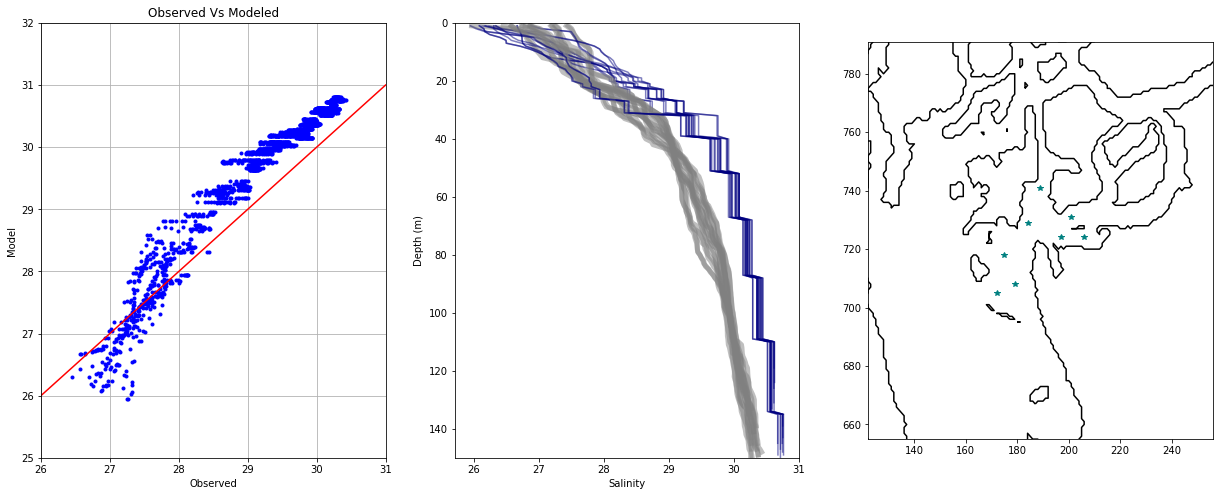

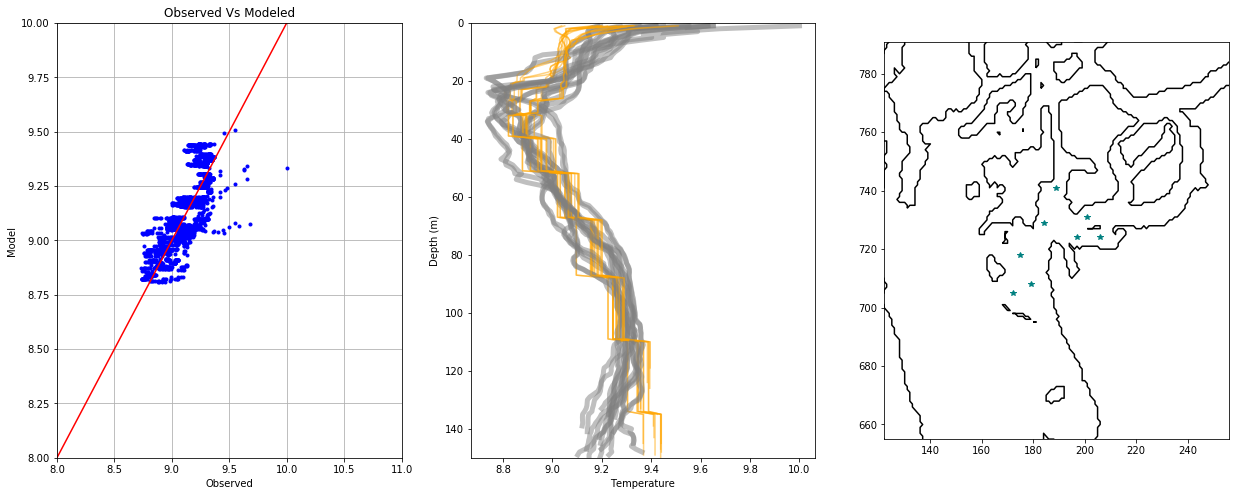

In [27]:
a, b = compare_one_day(Lund_one_day)
a[0].set_xlim(26,31)
a[0].set_ylim(25, 32);
b[0].set_ylim(8,10)
b[0].set_xlim(8,11)
b[0].plot(np.arange(7,12), np.arange(7,12), 'r-');

## June 28, 2016

salinity: bias =  0.145030808658
salinity: RMSE = 0.704294616485
salinity: Willmott = 0.950411260549
temperature: bias =  -0.0031937714657
temperature: RMSE = 0.357075702086
temperature: Willmott = 0.99026698803


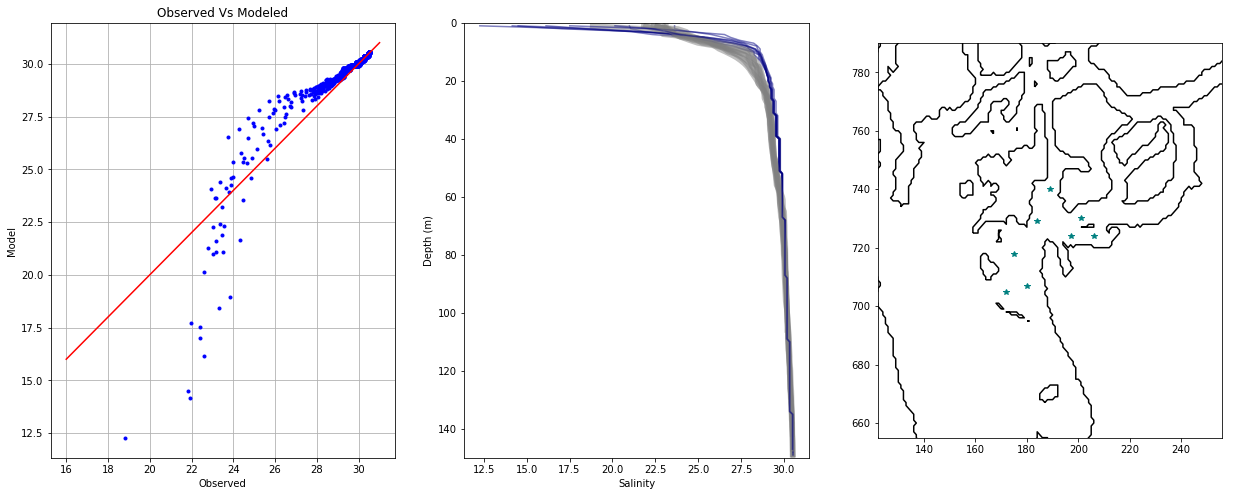

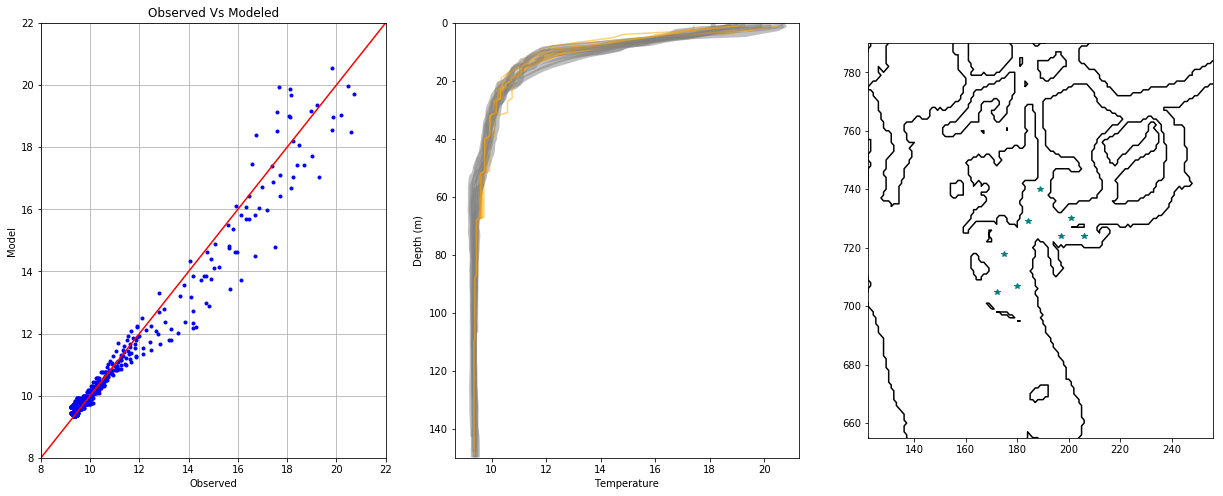

In [28]:
Lund_one_day_2016 = Lund.loc[Lund['date'] == Lund['date'].unique()[-10]]
c, d = compare_one_day(Lund_one_day_2016);
d[0].set_ylim(8,22)
d[0].set_xlim(8,22)
d[0].plot(np.arange(7,12), np.arange(7,12), 'r-');

In [29]:
second  = stationdata.loc[stationdata['patrol'] == 2]

# Powell River

## March 13, 2015

salinity: bias =  0.627952899031
salinity: RMSE = 0.744588232215
salinity: Willmott = 0.824618773108
temperature: bias =  -0.103586019714
temperature: RMSE = 0.156630012708
temperature: Willmott = 0.832000777716


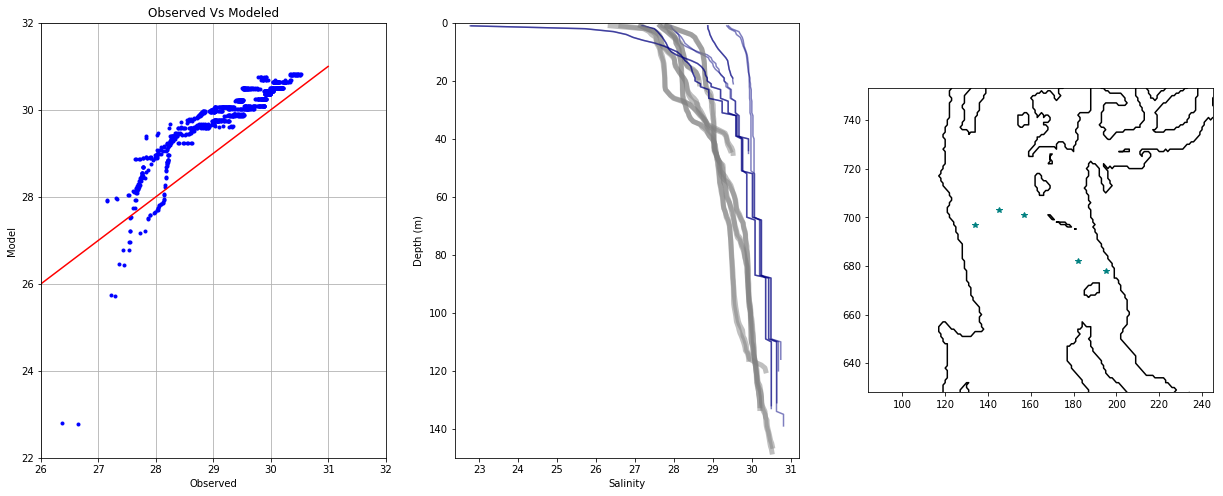

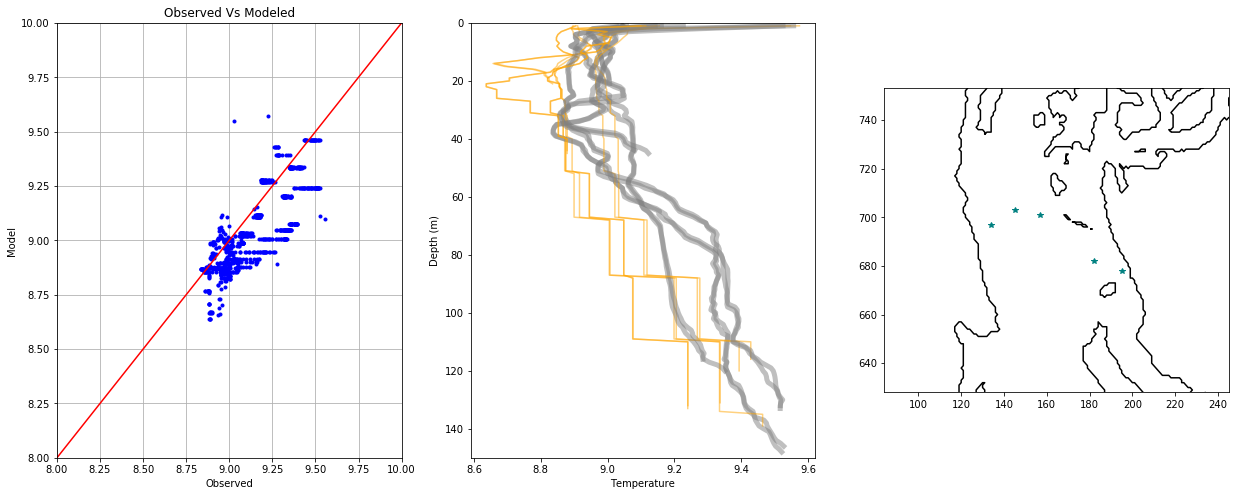

In [30]:
PR_one_day_2015 = second.loc[second['date'] == second['date'].unique()[10]]
b, c = compare_one_day(PR_one_day_2015)
b[0].set_xlim(26,32)
b[0].set_ylim(22,32);
c[0].set_ylim(8,10)
c[0].set_xlim(8,10)
c[0].plot(np.arange(7,12), np.arange(7,12), 'r-');

## August 3, 2016

salinity: bias =  -0.107401286615
salinity: RMSE = 0.618943413491
salinity: Willmott = 0.909342546811
temperature: bias =  -0.00459376403123
temperature: RMSE = 0.535043766647
temperature: Willmott = 0.971047954376


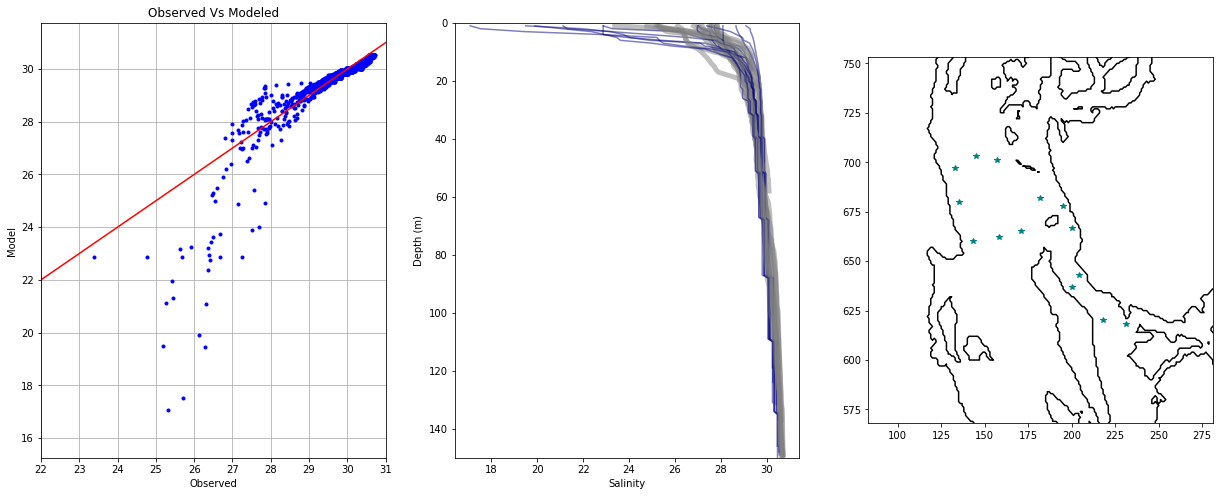

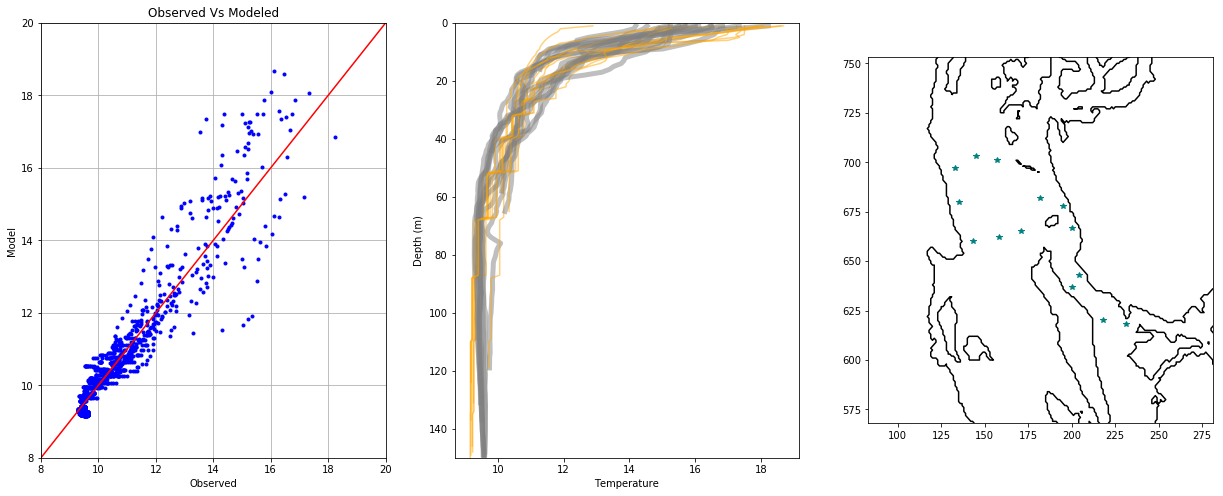

In [31]:
PR_one_day_2016 = second.loc[second['date'] == second['date'].unique()[-10]]
c, d = compare_one_day(PR_one_day_2016)
c[0].set_xlim(22,31);
d[0].set_xlim(8,20)
d[0].set_ylim(8,20)
d[0].plot(np.arange(7,12), np.arange(7,12), 'r-');

In [32]:
third  = stationdata.loc[stationdata['patrol'] == 3]

# Irvine/Sechelt

## June 24, 2015

salinity: bias =  -0.227238376963
salinity: RMSE = 0.759629275015
salinity: Willmott = 0.953577219938
temperature: bias =  -0.00198898867616
temperature: RMSE = 0.530194729129
temperature: Willmott = 0.986575381015


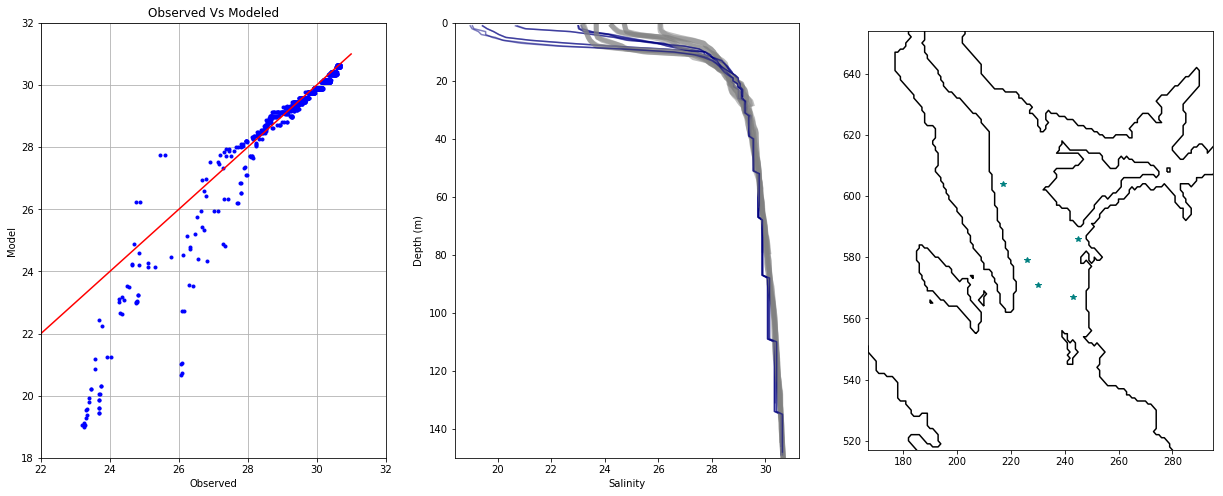

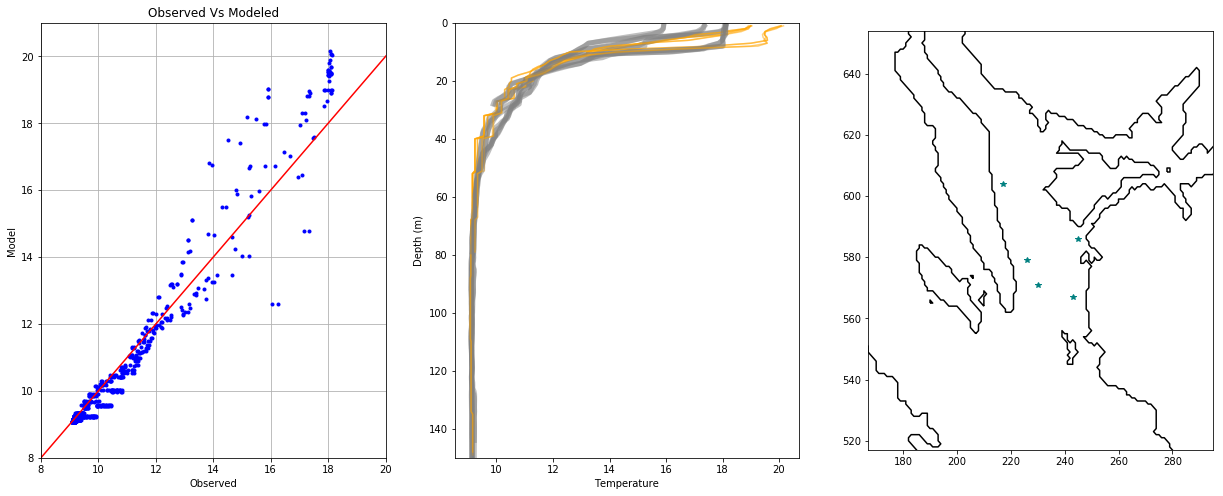

In [33]:
q, w = compare_one_day(third.loc[third['date'] == third['date'].unique()[10]]);
q[0].set_xlim(22, 32)
q[0].set_ylim(18, 32)
w[0].set_xlim(8, 20)
w[0].set_ylim(8, 21)
w[0].plot(np.arange(7, 11), np.arange(7,11), 'r-');

## June 15, 2016

salinity: bias =  0.0870729941417
salinity: RMSE = 0.797843574515
salinity: Willmott = 0.975238878883
temperature: bias =  0.0453789107747
temperature: RMSE = 0.431003546251
temperature: Willmott = 0.988212398239


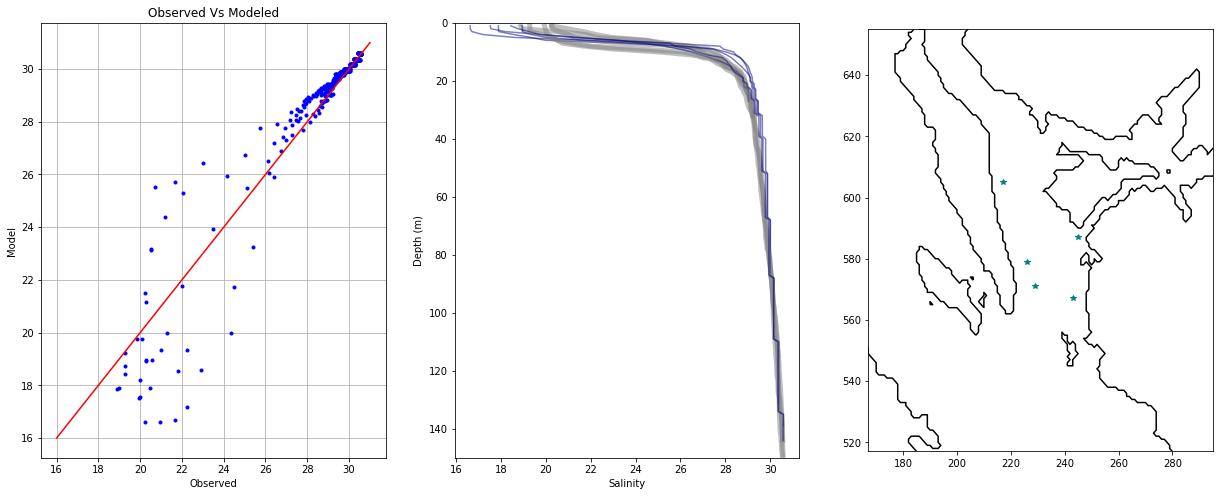

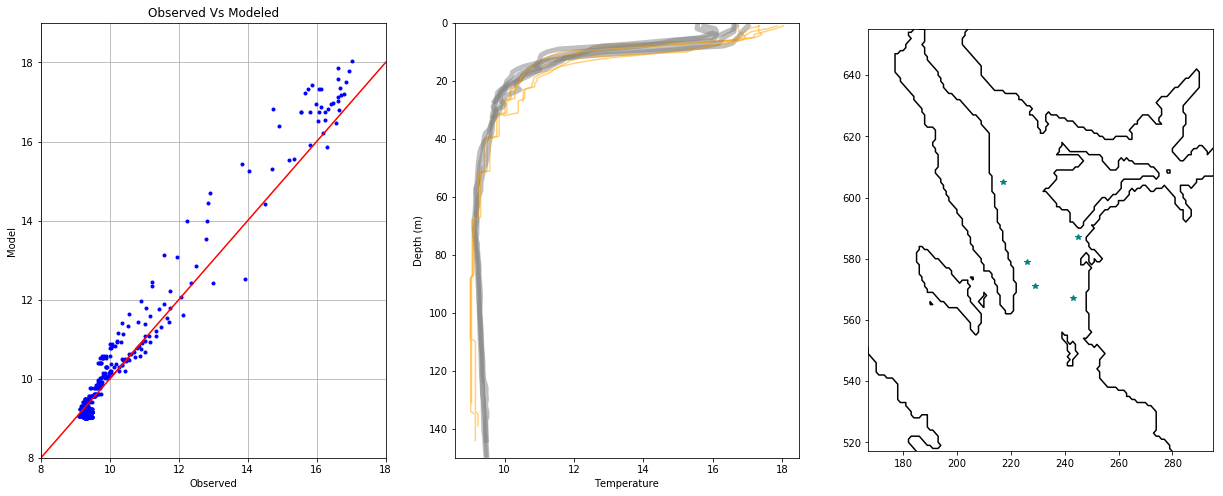

In [34]:
t, y = compare_one_day(third.loc[third['date'] == third['date'].unique()[-10]]);
y[0].set_xlim(8, 18)
y[0].set_ylim(8, 19)
y[0].plot(np.arange(7,12), np.arange(7, 12), 'r-');

In [35]:
fourth  = stationdata.loc[stationdata['patrol'] == 4]

# Baynes Sound

## June 8, 2015

salinity: bias =  -0.036017464165
salinity: RMSE = 0.421034682719
salinity: Willmott = 0.984442330285
temperature: bias =  -0.316447124394
temperature: RMSE = 1.29420019927
temperature: Willmott = 0.95331228706


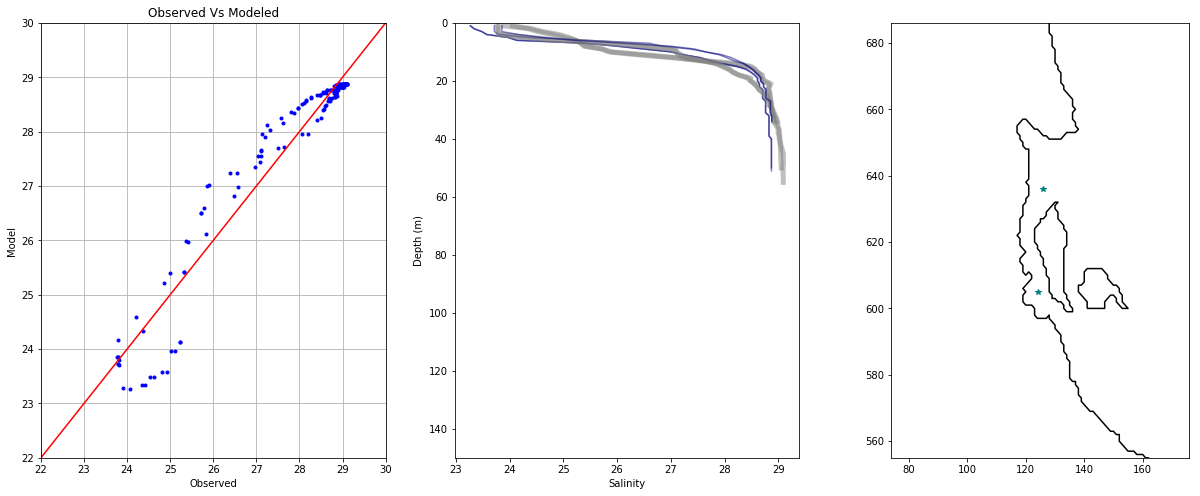

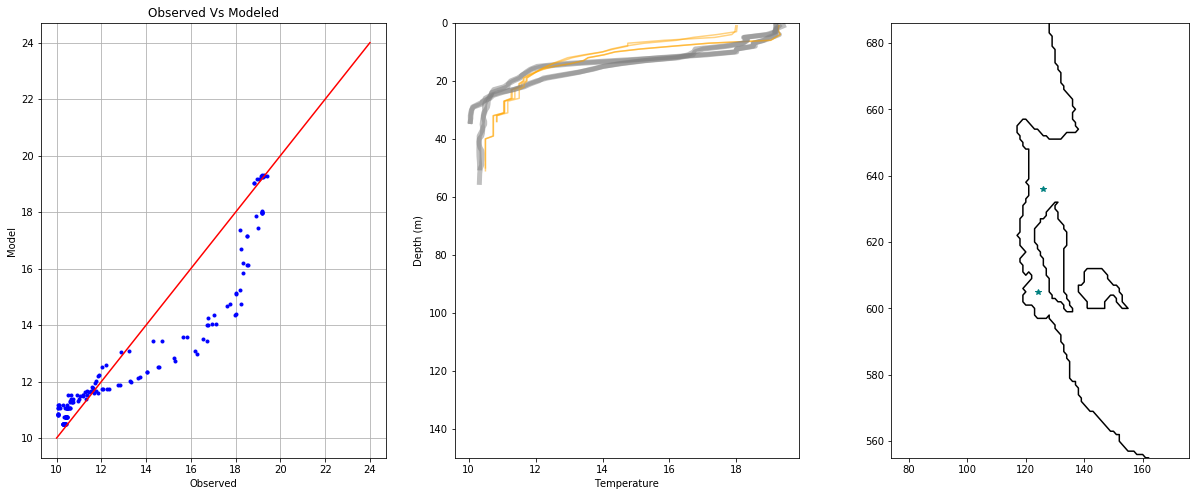

In [36]:
e, f = compare_one_day(fourth.loc[fourth['date'] == fourth['date'].unique()[10]])
e[0].set_xlim(22,30)
e[0].set_ylim(22,30);

## June 29, 2016

salinity: bias =  -0.196064522035
salinity: RMSE = 0.690428561643
salinity: Willmott = 0.923183787327
temperature: bias =  0.0955840332083
temperature: RMSE = 0.371461772877
temperature: Willmott = 0.994899543149


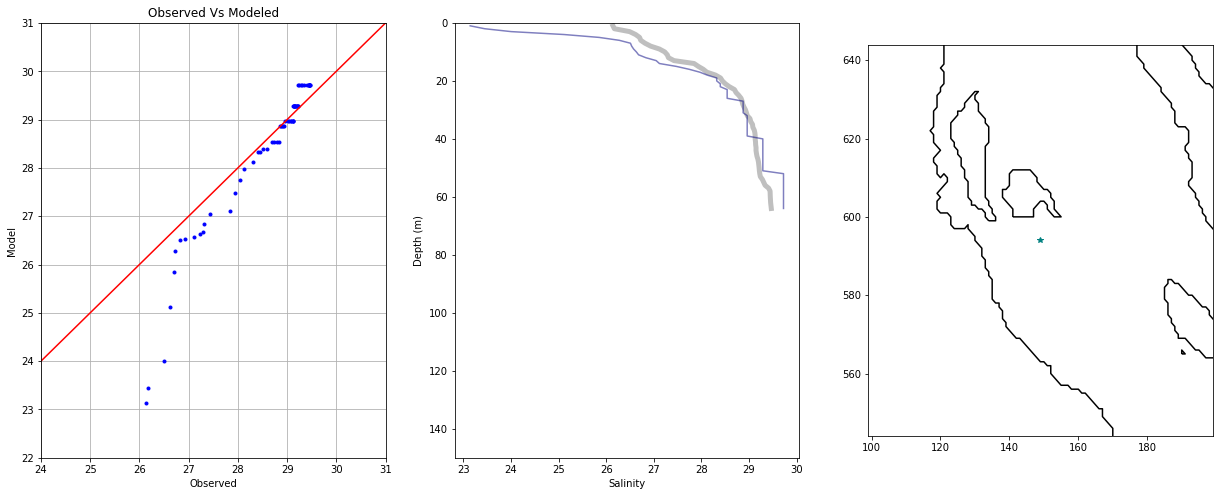

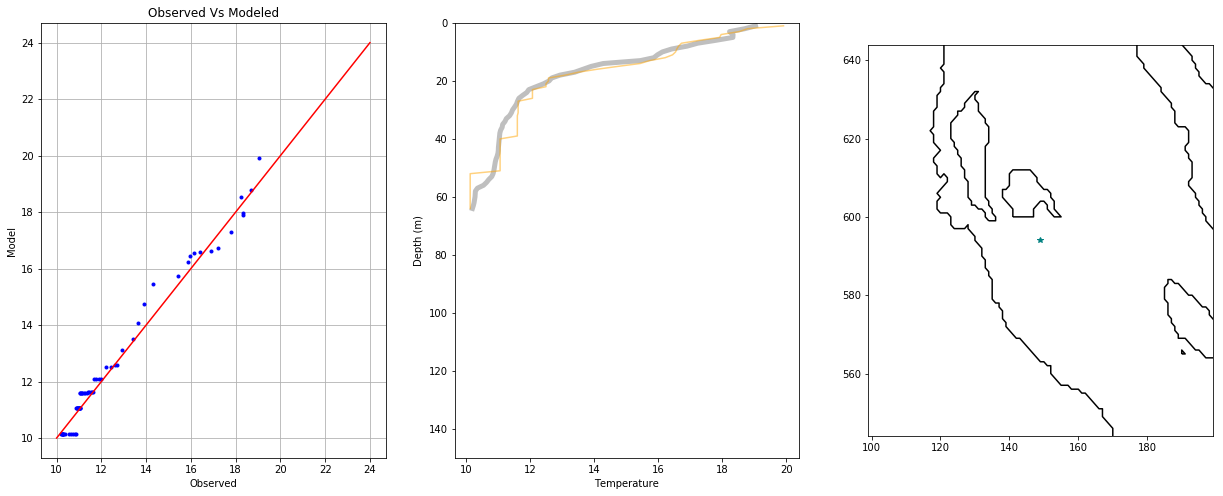

In [37]:
f, g = compare_one_day(fourth.loc[fourth['date'] == fourth['date'].unique()[-10]]);
f[0].set_xlim(24, 31)
f[0].set_ylim(22, 31);

In [38]:
fifth = stationdata.loc[stationdata['patrol'] == 5]

# Nanaimo

## July 1, 2015

salinity: bias =  -0.076687324803
salinity: RMSE = 0.318572890607
salinity: Willmott = 0.974238927724
temperature: bias =  -0.0605978723328
temperature: RMSE = 0.562444887561
temperature: Willmott = 0.980262412641


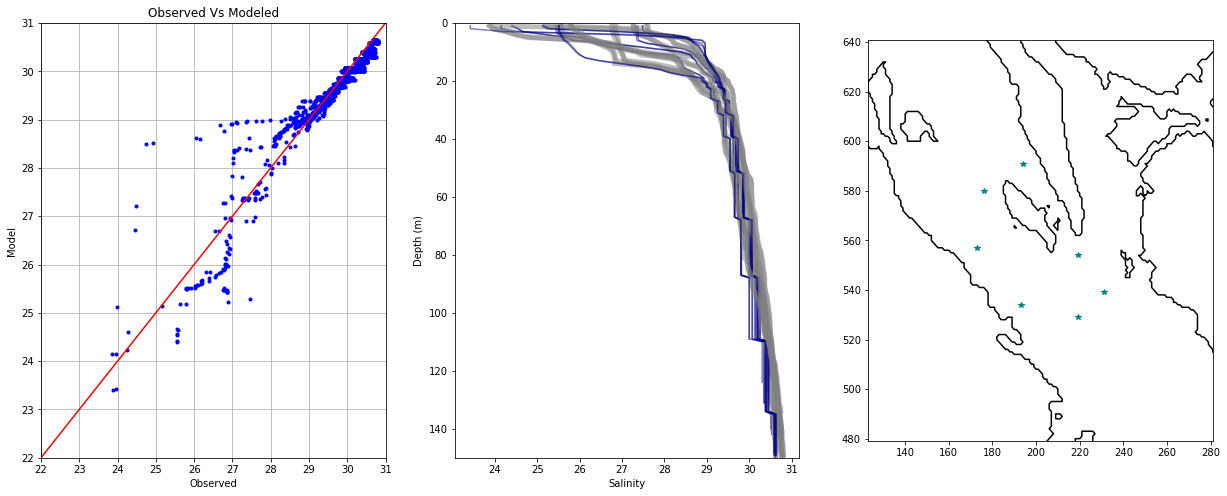

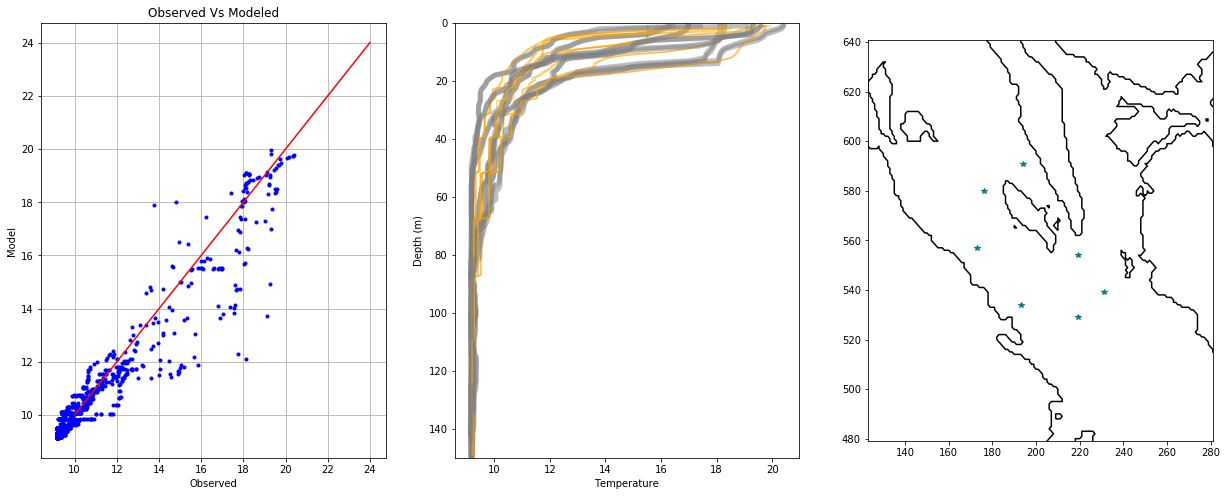

In [39]:
g, h= compare_one_day(fifth.loc[fifth['date'] == fifth['date'].unique()[10]])
g[0].set_xlim(22, 31)
g[0].set_ylim(22, 31);

## June 30, 2016

salinity: bias =  -0.0333229503771
salinity: RMSE = 0.374844549346
salinity: Willmott = 0.979161366285
temperature: bias =  -0.229154007552
temperature: RMSE = 0.517832940672
temperature: Willmott = 0.986312187687


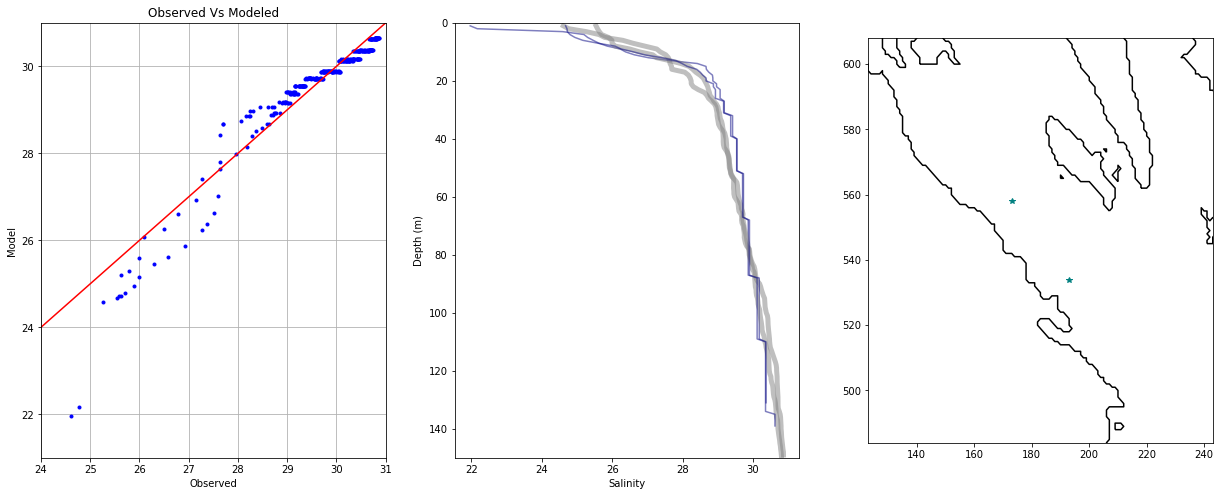

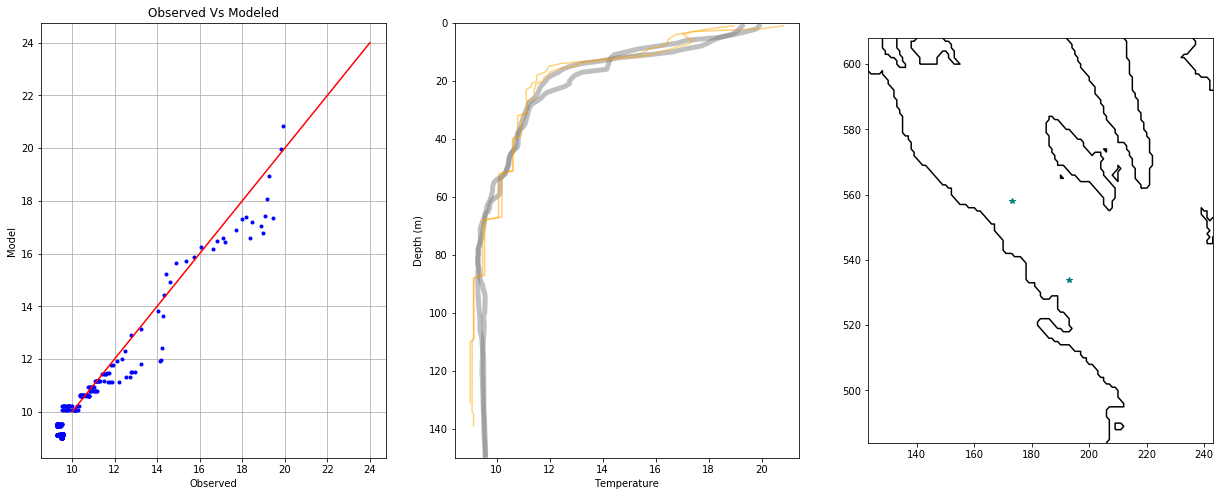

In [40]:
h, i = compare_one_day(fifth.loc[fifth['date'] == fifth['date'].unique()[-10]])
h[0].set_xlim(24, 31)
h[0].set_ylim(21, 31);

In [41]:
sixth = stationdata.loc[stationdata['patrol'] == 6]

# Campbell River

## May 25, 2015

salinity: bias =  0.0186203904192
salinity: RMSE = 0.424974359165
salinity: Willmott = 0.923335410181
temperature: bias =  -0.412941528604
temperature: RMSE = 0.730746683236
temperature: Willmott = 0.916733045004


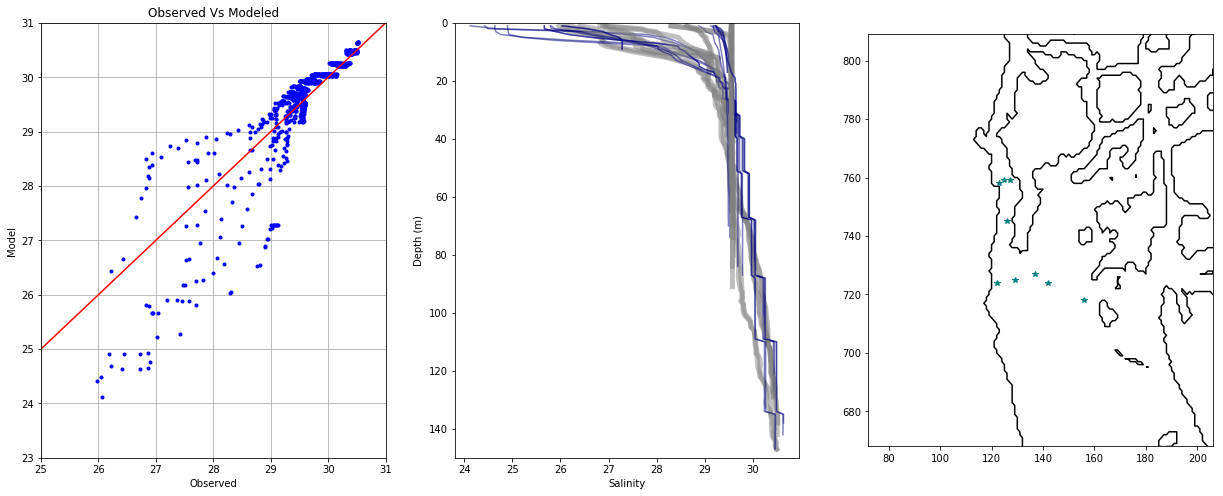

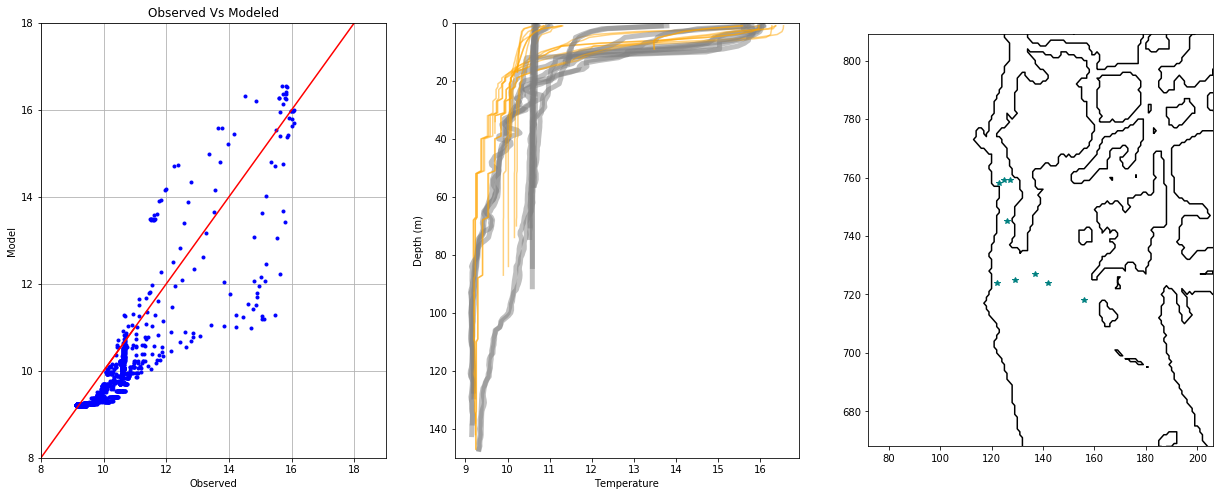

In [42]:
i, j = compare_one_day(sixth.loc[sixth['date'] == sixth['date'].unique()[10]])
i[0].set_xlim(25, 31)
i[0].set_ylim(23, 31);
j[0].set_ylim(8,18)
j[0].set_xlim(8,19)
j[0].plot(np.arange(7,12), np.arange(7,12), 'r-');

## June 29, 2016

salinity: bias =  -0.00174601403222
salinity: RMSE = 0.420045770598
salinity: Willmott = 0.962929854696
temperature: bias =  0.0518617115496
temperature: RMSE = 0.492020909988
temperature: Willmott = 0.973288439707


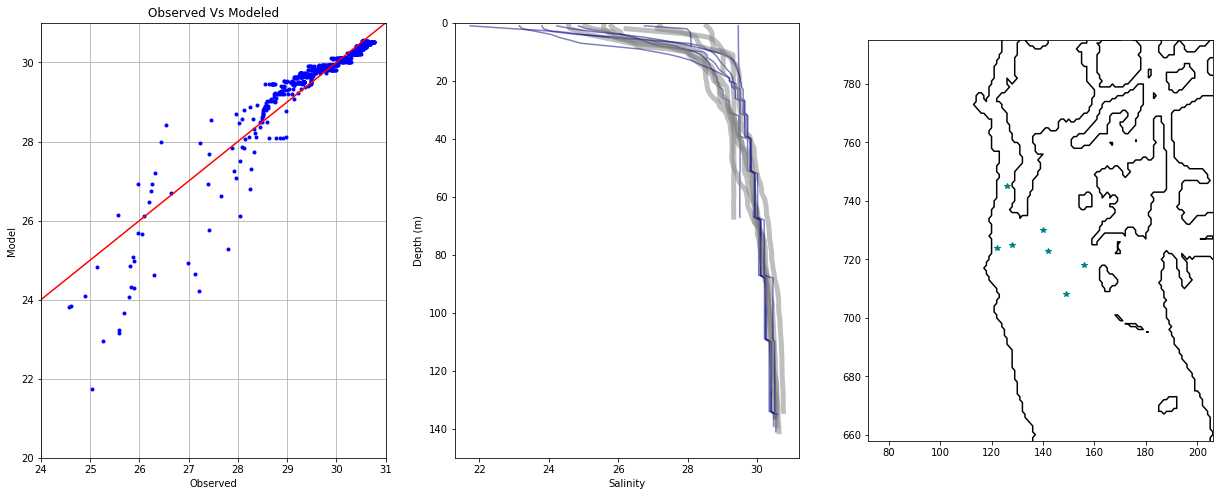

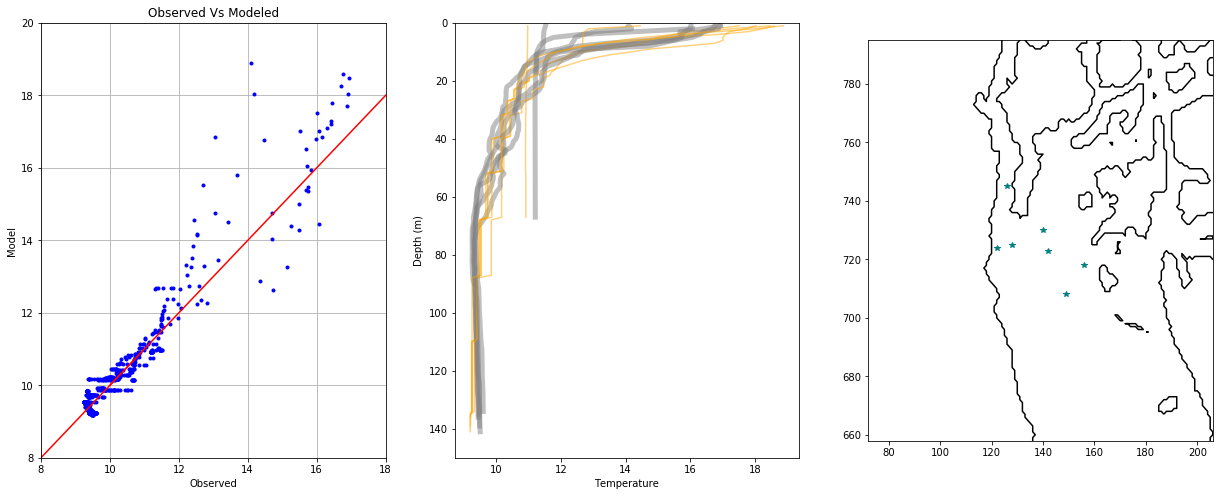

In [43]:
j, k = compare_one_day(sixth.loc[sixth['date'] == sixth['date'].unique()[-10]])
j[0].set_xlim(24, 31)
j[0].set_ylim(20, 31);
k[0].set_xlim(8,18)
k[0].set_ylim(8,20)
k[0].plot(np.arange(7,12), np.arange(7,12), 'r-');

In [44]:
seventh = stationdata.loc[stationdata['patrol'] == 7]

# Ladysmith

## May 27, 2015

salinity: bias =  -0.727814666253
salinity: RMSE = 0.962594741588
salinity: Willmott = 0.804586194768
temperature: bias =  0.512766545849
temperature: RMSE = 0.698922627819
temperature: Willmott = 0.968852627423


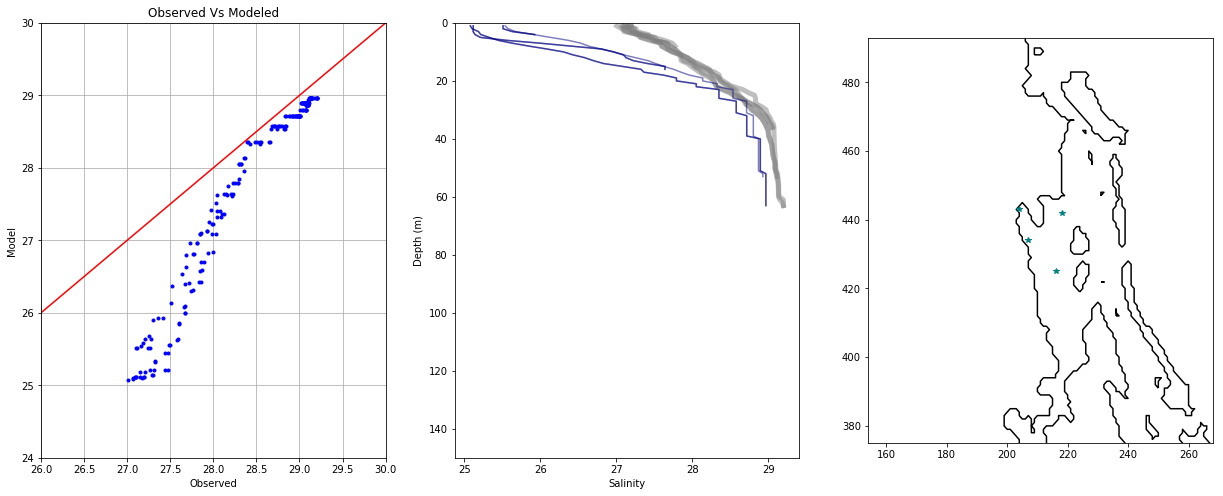

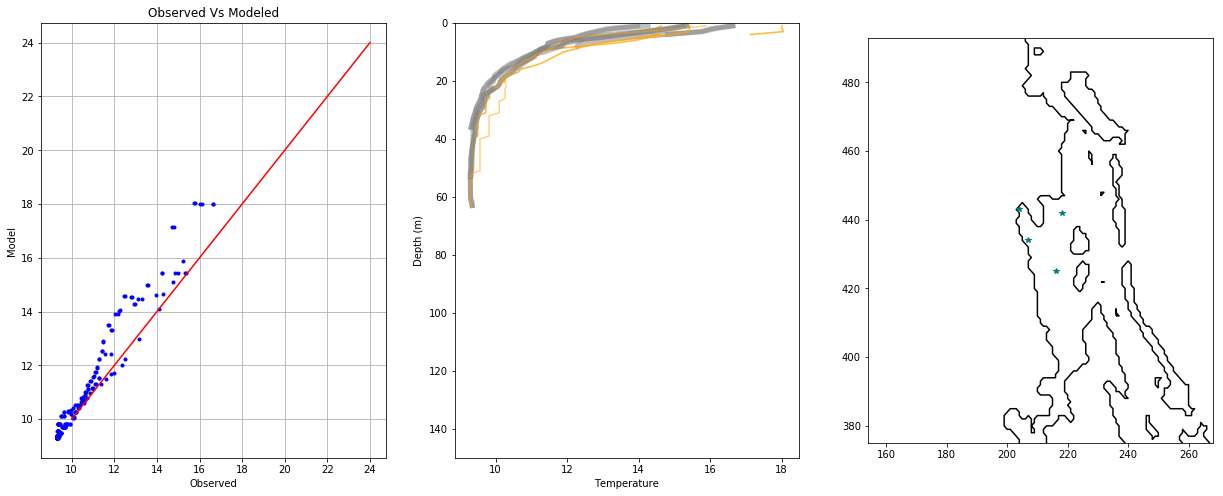

In [45]:
k, l = compare_one_day(seventh.loc[seventh['date'] == seventh['date'].unique()[1]])
k[0].set_xlim(26, 30)
k[0].set_ylim(24, 30);

## June 6, 2016

salinity: bias =  -0.729413404531
salinity: RMSE = 1.00772528681
salinity: Willmott = 0.789059906347
temperature: bias =  0.380114750568
temperature: RMSE = 0.72664285466
temperature: Willmott = 0.952781615281


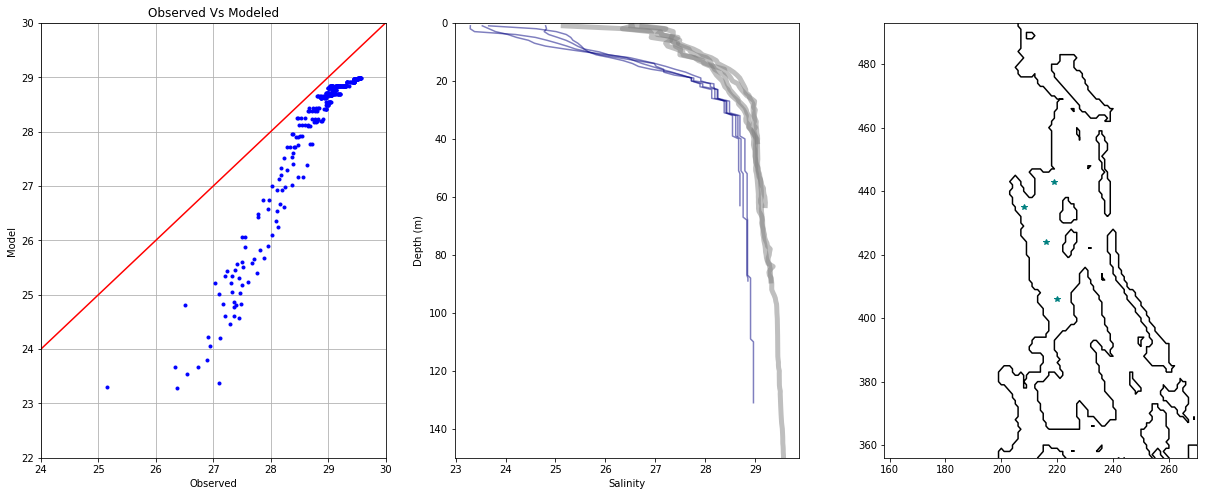

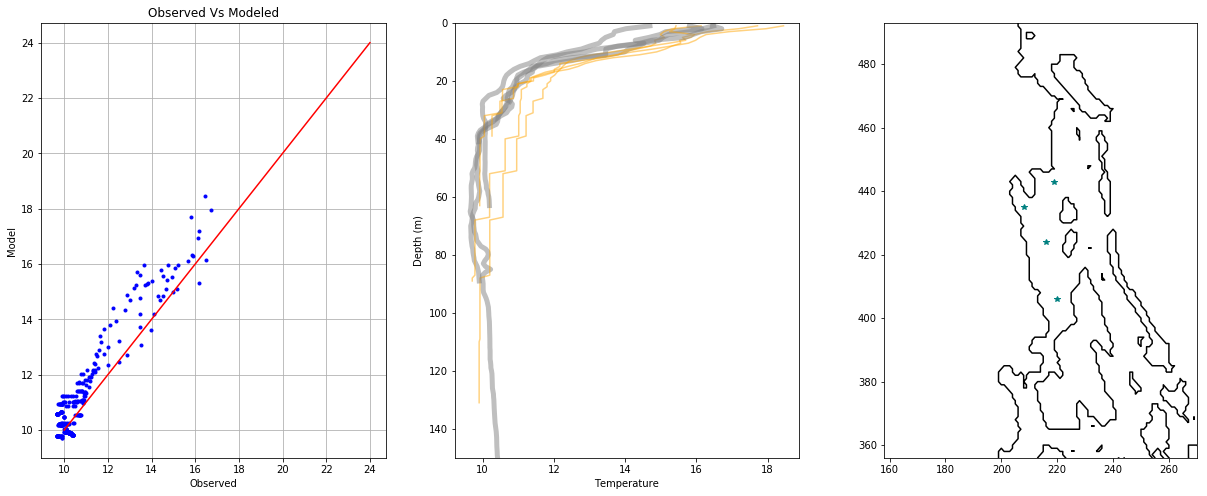

In [46]:
l, m = compare_one_day(seventh.loc[seventh['date'] == seventh['date'].unique()[-1]])
l[0].set_xlim(24, 30)
l[0].set_ylim(22, 30);

In [47]:
eighth = stationdata.loc[stationdata['patrol'] == 8]

# Steveston

## July 15, 2015

salinity: bias =  -0.0554658772749
salinity: RMSE = 1.2651912277
salinity: Willmott = 0.945490422078
temperature: bias =  0.419630531597
temperature: RMSE = 0.856738126831
temperature: Willmott = 0.936645227832


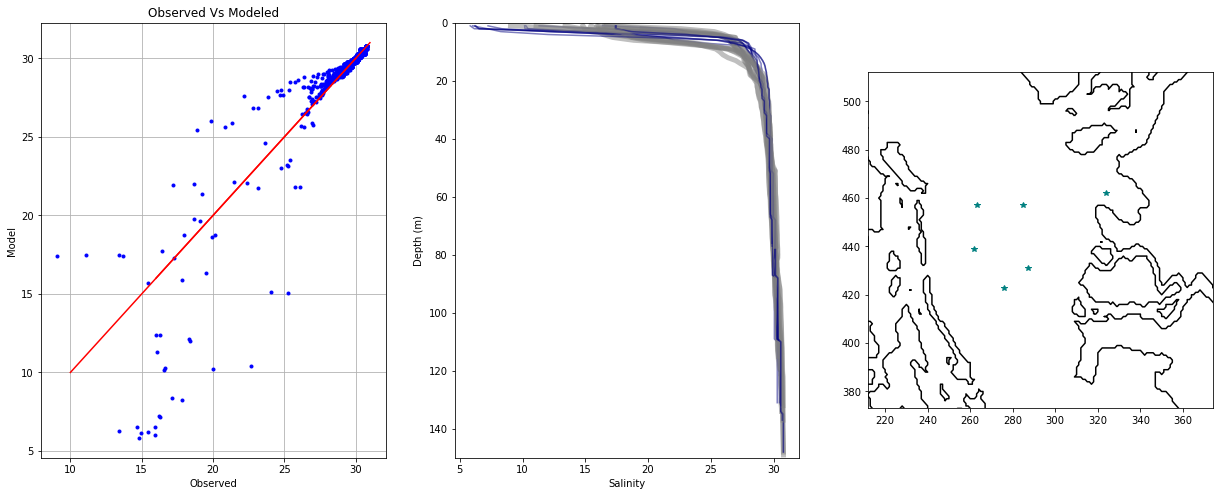

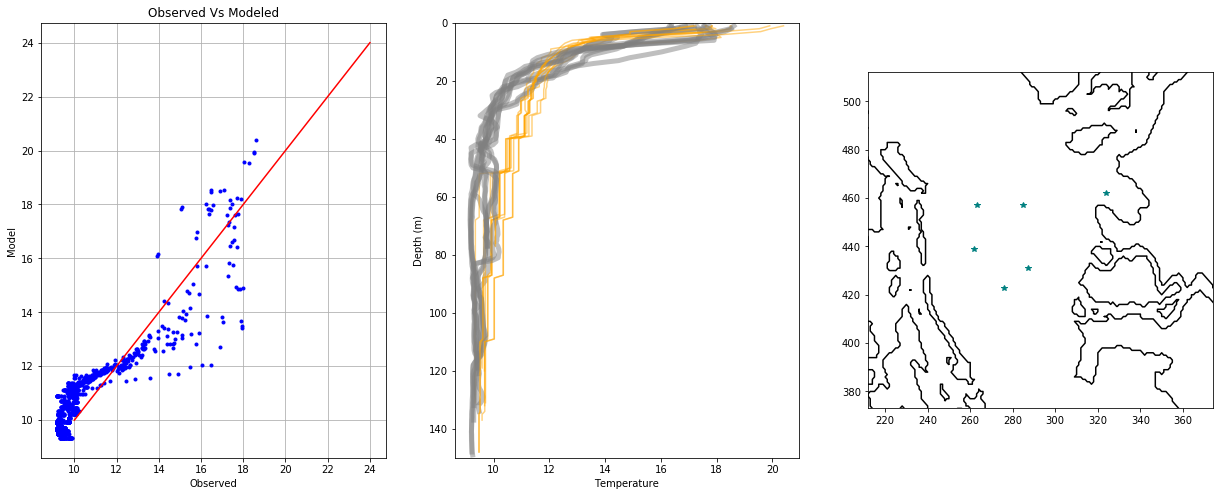

In [48]:
m, n = compare_one_day(eighth.loc[eighth['date'] == eighth['date'].unique()[1]])
m[0].plot(np.arange(10, 31), np.arange(10,31), 'r-');

## July 22, 2016

salinity: bias =  -0.226386595213
salinity: RMSE = 1.48636315548
salinity: Willmott = 0.90464179469
temperature: bias =  0.441203920958
temperature: RMSE = 0.804955204647
temperature: Willmott = 0.950601354307


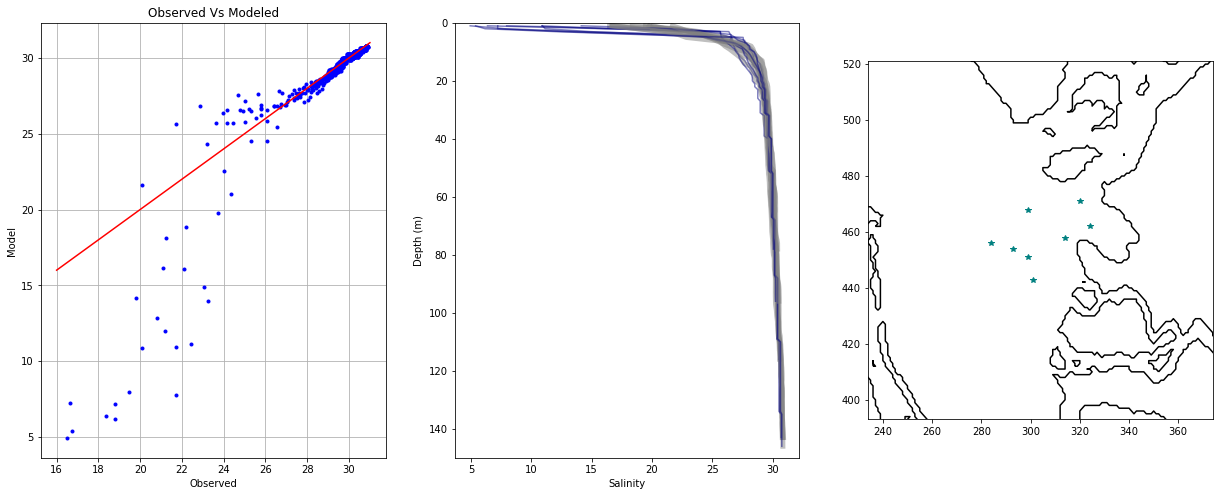

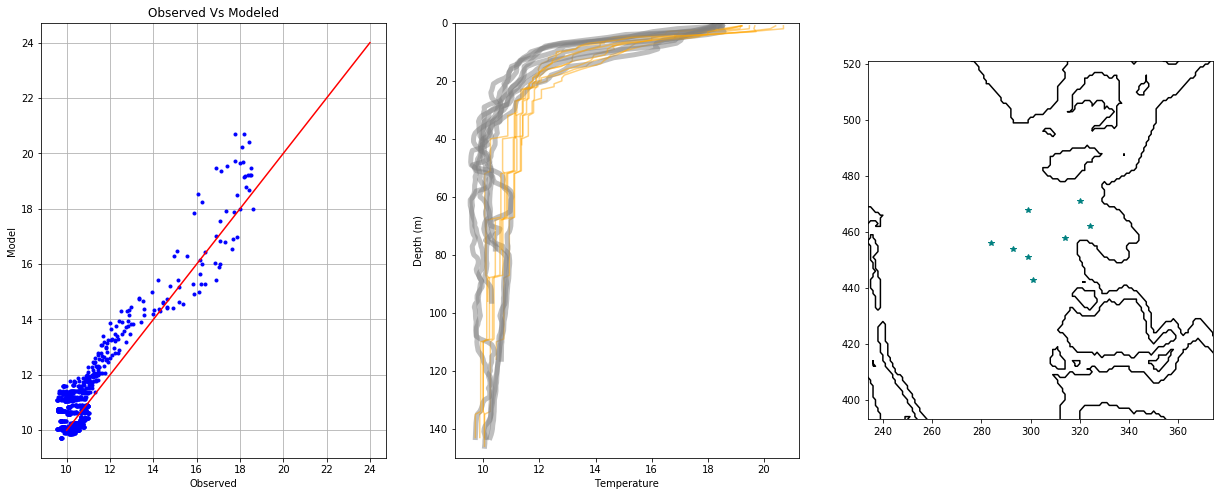

In [49]:
compare_one_day(eighth.loc[eighth['date'] == eighth['date'].unique()[-4]]);

In [50]:
ninth = stationdata.loc[stationdata['patrol'] == 9]

# Victoria

## May 27, 2015

salinity: bias =  0.0730269250191
salinity: RMSE = 0.257711758904
salinity: Willmott = 0.877373069618
temperature: bias =  0.166929045616
temperature: RMSE = 0.182331255053
temperature: Willmott = 0.589667536367


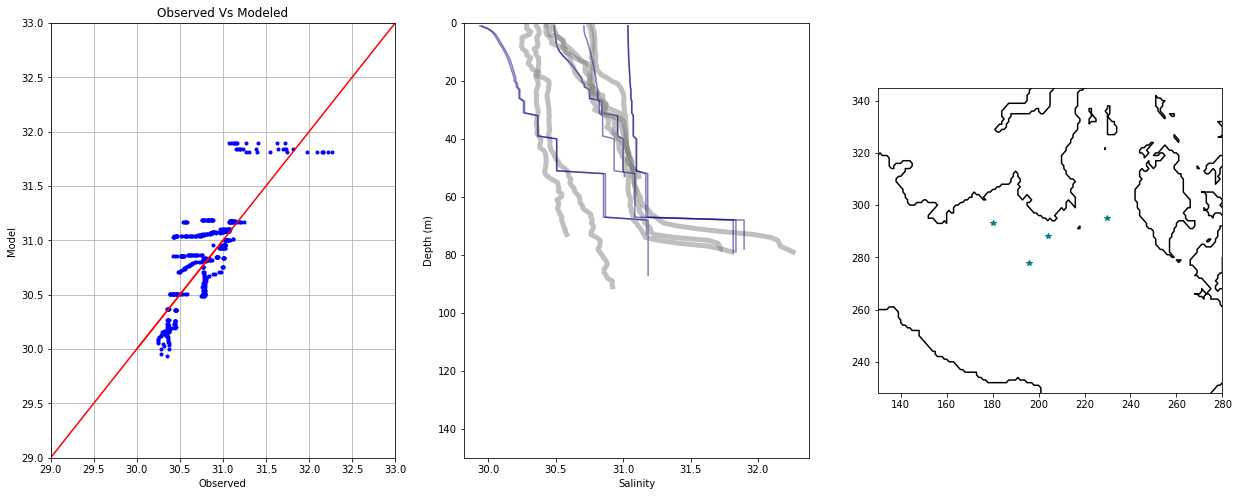

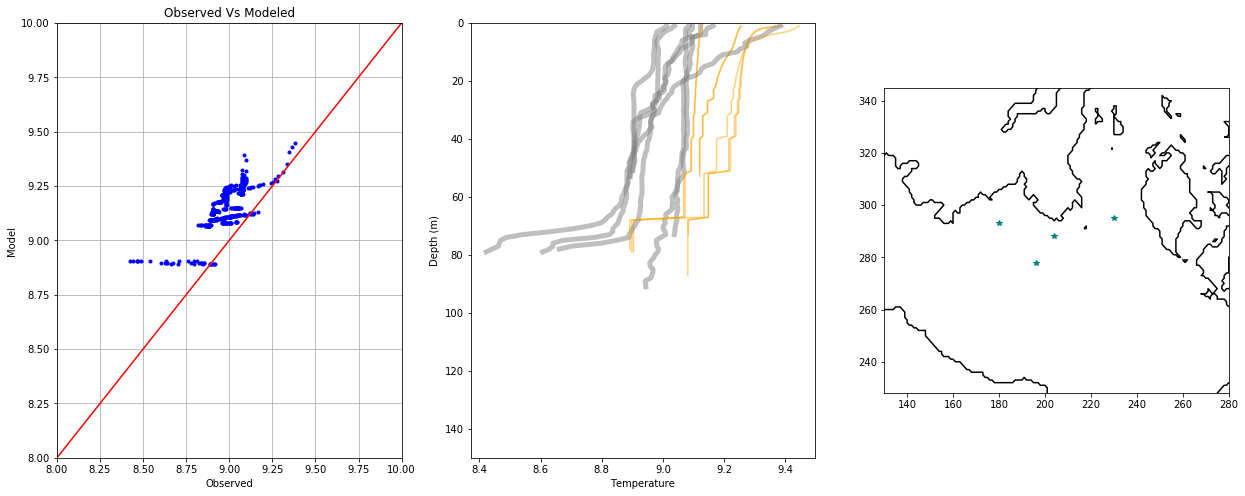

In [51]:
n, p = compare_one_day(ninth.loc[ninth['date'] == ninth['date'].unique()[4]])
n[0].set_xlim(29, 33)
n[0].set_ylim(29, 33)
n[0].plot(np.arange(30,34), np.arange(30,34), 'r-');
p[0].set_xlim(8,10)
p[0].set_ylim(8,10)
p[0].plot(np.arange(7,12), np.arange(7,12), 'r-');

# Galiano

## June 6, 2016

salinity: bias =  -0.290252003229
salinity: RMSE = 0.450141571295
salinity: Willmott = 0.963296477091
temperature: bias =  0.320110523238
temperature: RMSE = 0.575683434625
temperature: Willmott = 0.959354061178


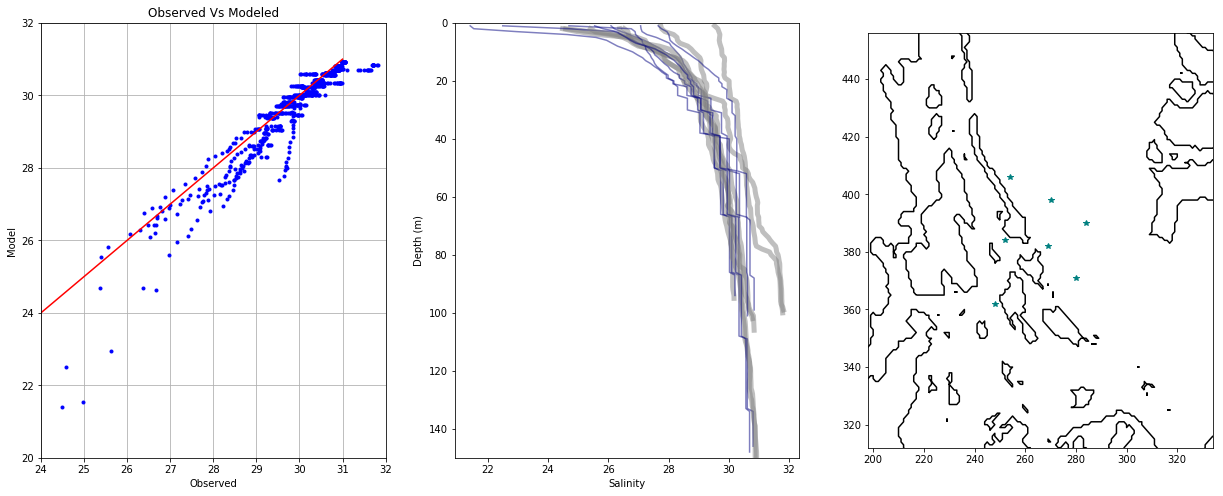

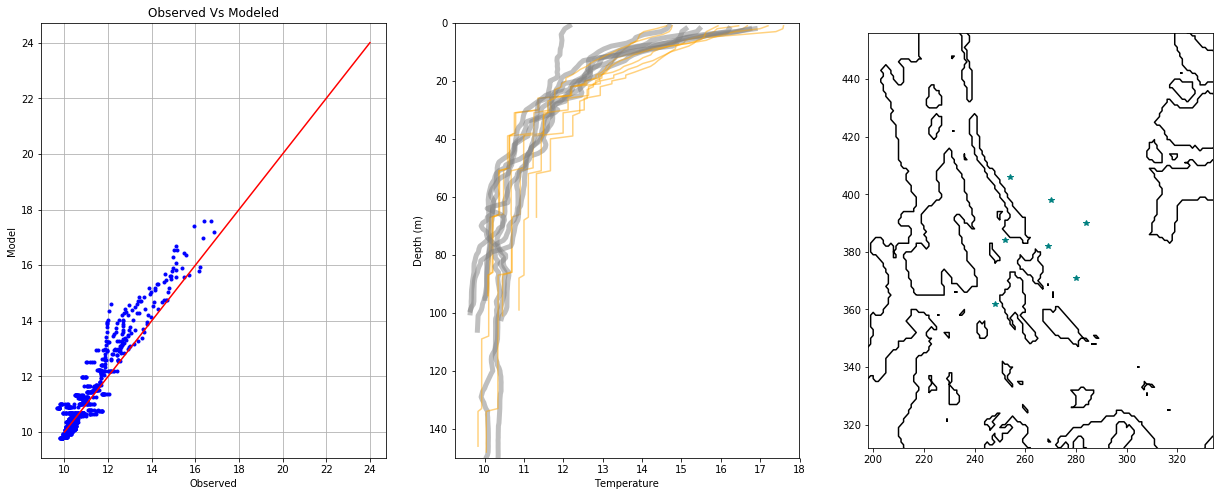

In [52]:
o, q = compare_one_day(ninth.loc[ninth['date'] == ninth['date'].unique()[-6]])
o[0].set_xlim(24, 32)
o[0].set_ylim(20, 32);

In [53]:
tenth = stationdata.loc[stationdata['patrol'] == 10]

# Cowichan Bay

## May 26, 2015

salinity: bias =  0.0910241050659
salinity: RMSE = 0.700376405082
salinity: Willmott = 0.824404335647
temperature: bias =  -0.261754841354
temperature: RMSE = 0.319709548826
temperature: Willmott = 0.229459371211


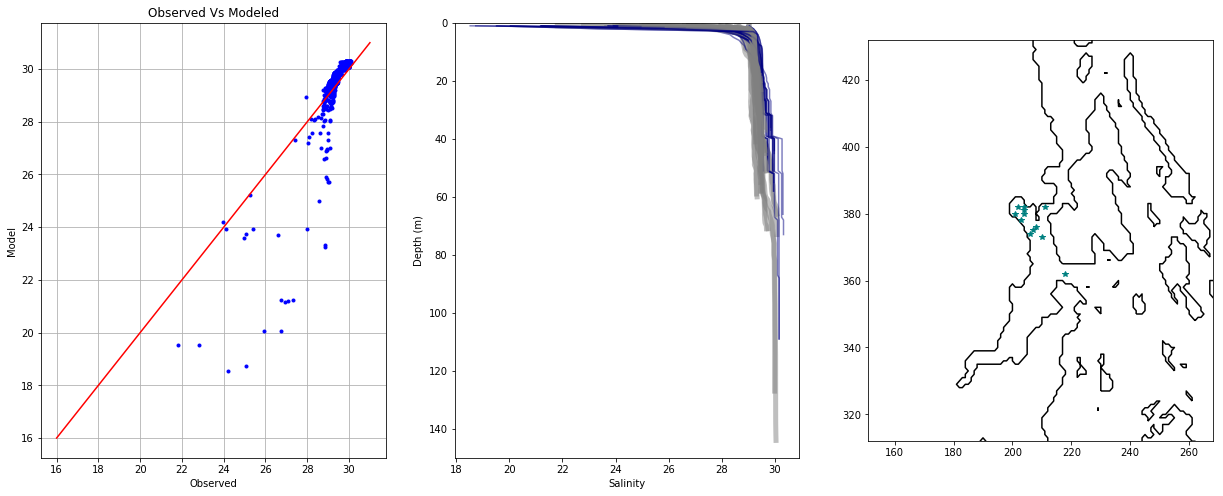

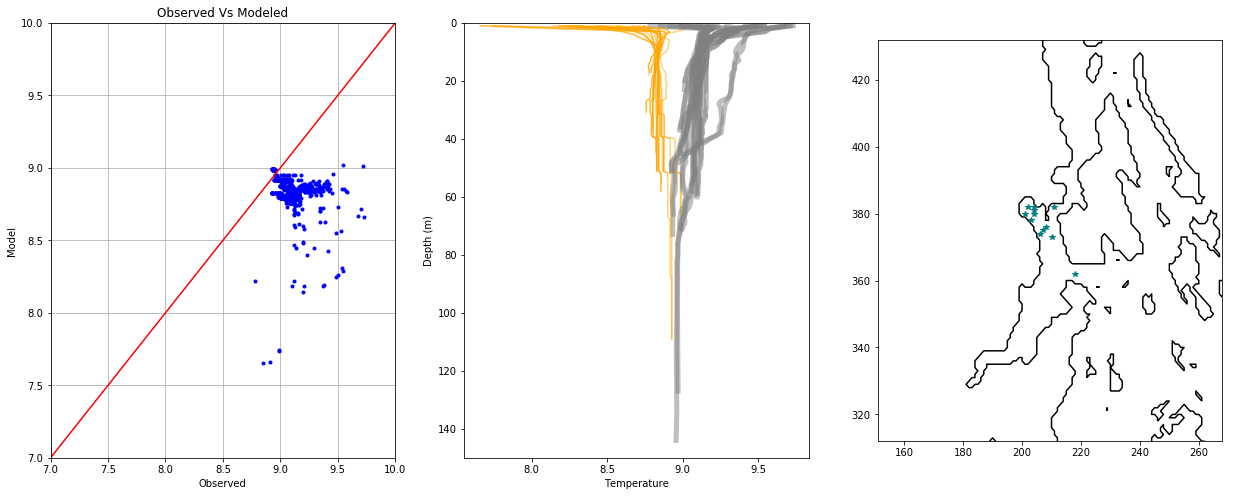

In [54]:
t, r = compare_one_day(tenth.loc[tenth['date'] == tenth['date'].unique()[4]]);
r[0].set_ylim(7, 10)
r[0].set_xlim(7,10)
r[0].plot(np.arange(6,12), np.arange(6, 12), 'r-');

## June 28, 2016

salinity: bias =  -0.784764606132
salinity: RMSE = 0.792783242983
salinity: Willmott = 0.637478392408
temperature: bias =  0.718224016319
temperature: RMSE = 0.660742055493
temperature: Willmott = 0.802623263048


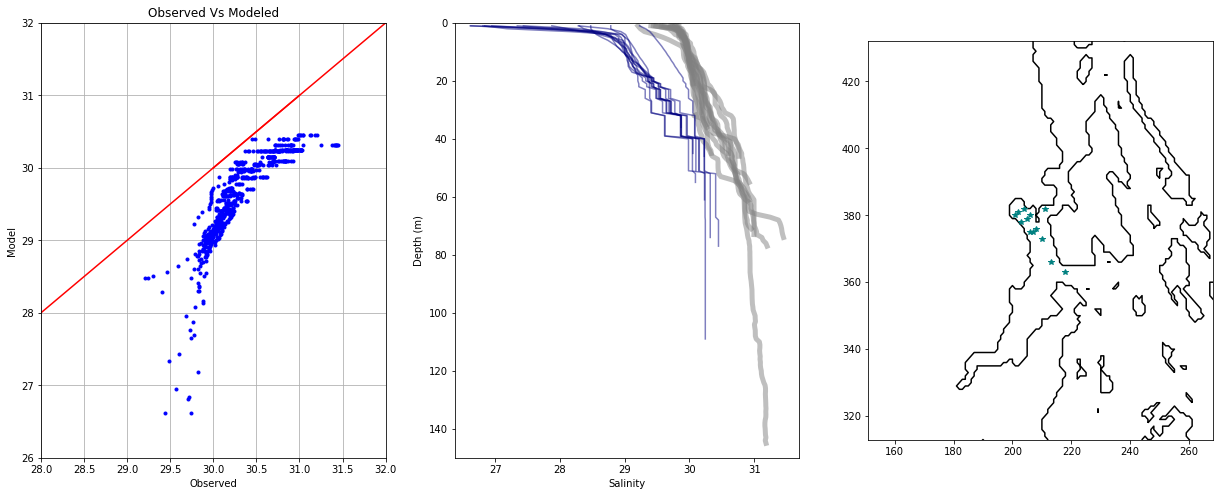

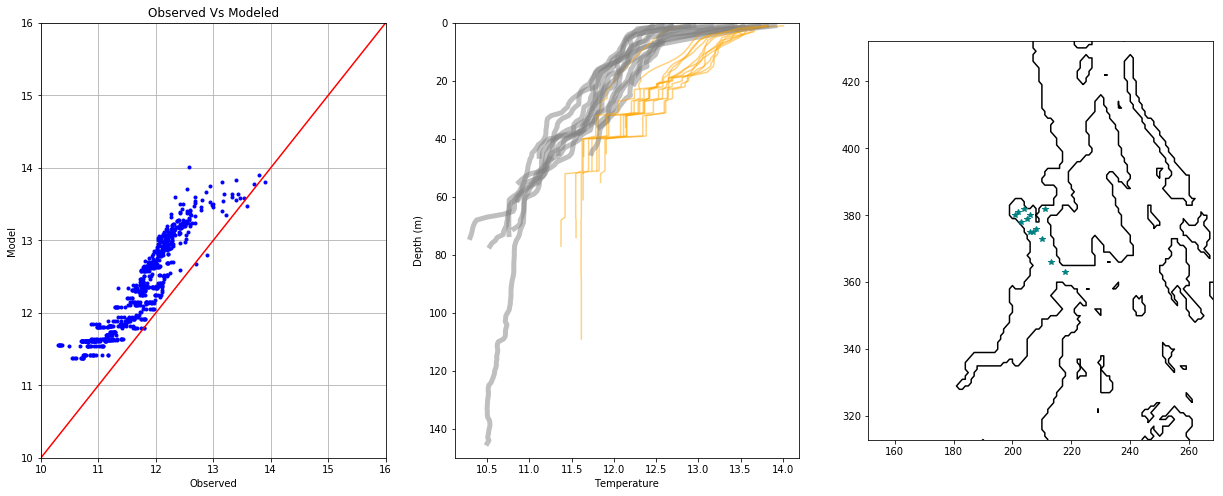

In [55]:
p, r = compare_one_day(tenth.loc[tenth['date'] == tenth['date'].unique()[-3]])
p[0].set_xlim(28, 32)
p[0].set_ylim(26, 32);
p[0].plot(np.arange(30, 33), np.arange(30, 33), 'r-')
r[0].set_xlim(10, 16)
r[0].set_ylim(10, 16);